# Imports

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import os
import glob
from functools import reduce

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# Loading in Data 
## Loading each file in seperately and mean converting sensors based on their sampling rate (Hertz)

In [13]:
# import all the feature variables at once
path = 'features/*.txt'
# find all the txt files in the path 
files = glob.glob(path)
# use a dict to save all the variables 
files

['features/SE.txt',
 'features/PS1.txt',
 'features/TS4.txt',
 'features/PS2.txt',
 'features/PS3.txt',
 'features/TS3.txt',
 'features/VS1.txt',
 'features/TS2.txt',
 'features/PS6.txt',
 'features/PS4.txt',
 'features/TS1.txt',
 'features/PS5.txt',
 'features/CP.txt',
 'features/CE.txt',
 'features/EPS1.txt',
 'features/FS1.txt',
 'features/FS2.txt']

In [14]:
# This will align all sensors to have the same frequency by averaging groups of columns
# based on their sampling rate (Hertz) to ensure the same amount of cycles and 1 second per reading. 
# This will allow us to not have to upsample or downsample.
# Will create a df with 2205 cycles with sensor readings for each second of the 60-second cycle. 


# import all the feature variables at once
path = 'features/*.txt'
# find all the txt files in the path 
files = glob.glob(path)
# use a dict to save all the variables 
features = {}

frequencies = {
    'PS1': 100,
    'PS2': 100,
    'PS3': 100,
    'PS4': 100,
    'PS5': 100,
    'PS6': 100,
    'EPS1': 100,
    'FS1': 10,
    'FS2': 10,
    'TS1': 1,
    'TS2': 1,
    'TS3': 1,
    'TS4': 1,
    'VS1': 1,
    'SE': 1,
    'CE': 1,
    'CP': 1
}

features = {}

for name in files:
    if name == 'features\\profile.txt':
        pass
    else:
        try:
            with open(name) as f:
                # Read in the data
                temp = pd.read_csv(name, sep = "\t", header=None)

                # Extract sensor name from the file name
                sensor_name = name[9:-4]
                sensor_frequency = frequencies[sensor_name]

                # Calculate the mean of every n columns based on the sensor frequency
                averaged_df = temp.groupby(temp.columns // sensor_frequency, axis=1).mean()

                # Transpose the matrix
                averaged_transposed_df = averaged_df.T

                # Reset index and rename the index column
                averaged_transposed_df.reset_index(inplace=True)
                averaged_transposed_df.rename(columns={'index': 'seconds'}, inplace=True)

                # Reshape the data from wide to long format
                melted_df = pd.melt(averaged_transposed_df, id_vars=['seconds'], var_name='cycle', value_name=sensor_name)

                # Update the seconds and cycle values to start from 1
                melted_df['seconds'] += 1
                melted_df['cycle'] += 1

                # Store the melted data frame in the features dictionary
                features[sensor_name] = melted_df

        except FileNotFoundError:
            print(f"File {name} not found")


In [15]:
# Create a list of data frames from the dictionary
data_frames = list(features.values())

# Define a function to merge two data frames on 'seconds' and 'cycle' columns
def merge_dataframes(df1, df2):
    return df1.merge(df2, on=['seconds', 'cycle'])

# Use the reduce function to merge all data frames in the list
merged_df = reduce(merge_dataframes, data_frames)

In [17]:
# Load in target variables
profile_df = pd.read_csv('profile.txt', sep="\t", header=None)

# Rename the columns
profile_df.columns = ['cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag']

# Duplicate each row 60 times
n_repeats = 60
repeated_index = np.repeat(profile_df.index, n_repeats)
profile_expanded_df = profile_df.loc[repeated_index].reset_index(drop=True)

# Add the 'seconds' and 'cycle' columns
profile_expanded_df['seconds'] = (np.arange(len(profile_expanded_df)) % n_repeats) + 1
profile_expanded_df['cycle'] = (np.arange(len(profile_expanded_df)) // n_repeats) + 1

In [18]:
# Concatenate the merged_df and profile_expanded_df
df = merge_dataframes(merged_df, profile_expanded_df)

In [19]:
# Create a date range starting from '2018-04-26 00:00:00' with a frequency of 1 second
start_date = pd.Timestamp('2018-04-26 00:00:00')
date_range = pd.date_range(start=start_date, periods=len(df), freq='S')

# Insert the date range as the first column of the dataframe
df.insert(0, 'date', date_range)

In [20]:
df

,date,seconds,cycle,SE,PS1,TS4,PS2,PS3,TS3,VS1,TS2,PS6,PS4,TS1,PS5,CP,CE,EPS1,FS1,FS2,cooler_condition,valve_condition,internal_pump_leakage,hydraulic_accumulator,stable_flag
0,2018-04-26 00:00:00,1,1,68.039,176.8996,30.363,11.86685,0.18954,38.320,0.604,40.961,9.84138,0.00000,35.570,9.96442,2.184,47.202,2613.468,1.0413,10.1691,3,100,0,130,1
1,2018-04-26 00:00:01,2,1,0.000,184.6420,30.375,0.18786,0.00000,38.332,0.605,40.949,9.83686,0.00000,35.492,9.95969,2.184,47.273,2917.282,0.0007,10.1704,3,100,0,130,1
2,2018-04-26 00:00:02,3,1,0.000,189.8996,30.367,0.02133,0.00000,38.320,0.611,40.965,9.83819,0.00000,35.469,9.96422,2.184,47.250,2861.840,0.0023,10.1641,3,100,0,130,1
3,2018-04-26 00:00:03,4,1,0.000,191.3442,30.367,0.00283,0.00000,38.324,0.603,40.922,9.84618,0.00000,35.422,9.96867,2.185,47.332,2946.474,0.0008,10.1751,3,100,0,130,1
4,2018-04-26 00:00:04,5,1,0.000,191.2833,30.379,0.00000,0.00000,38.332,0.608,40.879,9.84887,0.00000,35.414,9.97288,2.178,47.213,2946.164,0.0014,10.1730,3,100,0,130,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132295,2018-04-27 12:44:55,56,2205,68.167,151.7397,30.395,125.67640,2.35381,38.195,0.516,40.910,9.85935,10.21349,35.441,9.98025,2.134,46.355,2415.880,7.8623,10.1889,100,100,0,90,0
132296,2018-04-27 12:44:56,57,2205,68.167,151.7571,30.391,125.67780,2.32953,38.184,0.528,40.895,9.86011,10.21272,35.437,9.98103,2.146,46.432,2415.692,7.8369,10.1826,100,100,0,90,0
132297,2018-04-27 12:44:57,58,2205,68.258,151.7946,30.395,125.72750,2.35844,38.184,0.522,40.883,9.86092,10.21637,35.434,9.97812,2.144,46.384,2416.870,7.8729,10.1862,100,100,0,90,0
132298,2018-04-27 12:44:58,59,2205,68.258,151.7378,30.402,125.71310,2.29595,38.184,0.522,40.879,9.86093,10.21528,35.434,9.98258,2.136,46.479,2415.968,7.8685,10.1861,100,100,0,90,0


In [51]:
df.to_csv("same_sensory_rate_data.csv", index=False)

# Visualizations

<Axes: xlabel='date'>

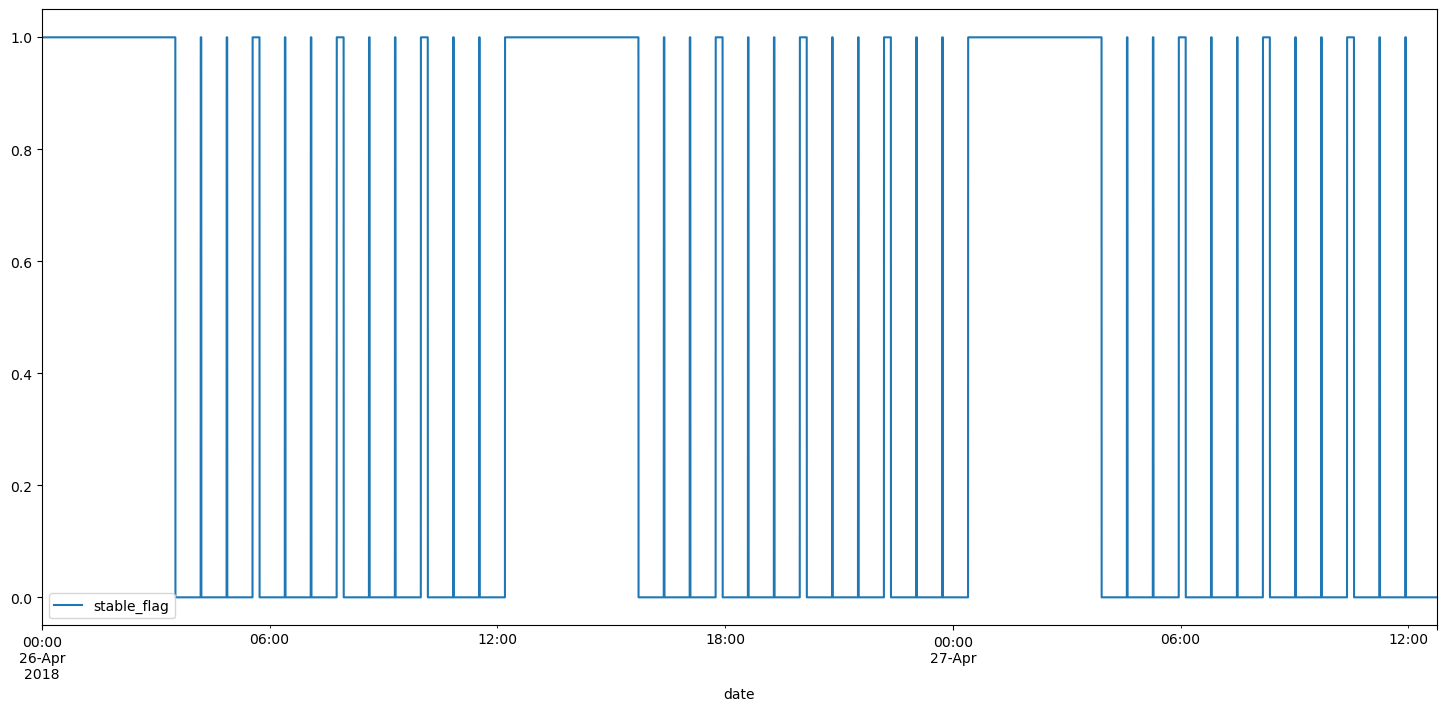

In [21]:
fig, ax = plt.subplots(figsize=(18, 8))

df.plot('date', 'stable_flag', ax=ax)

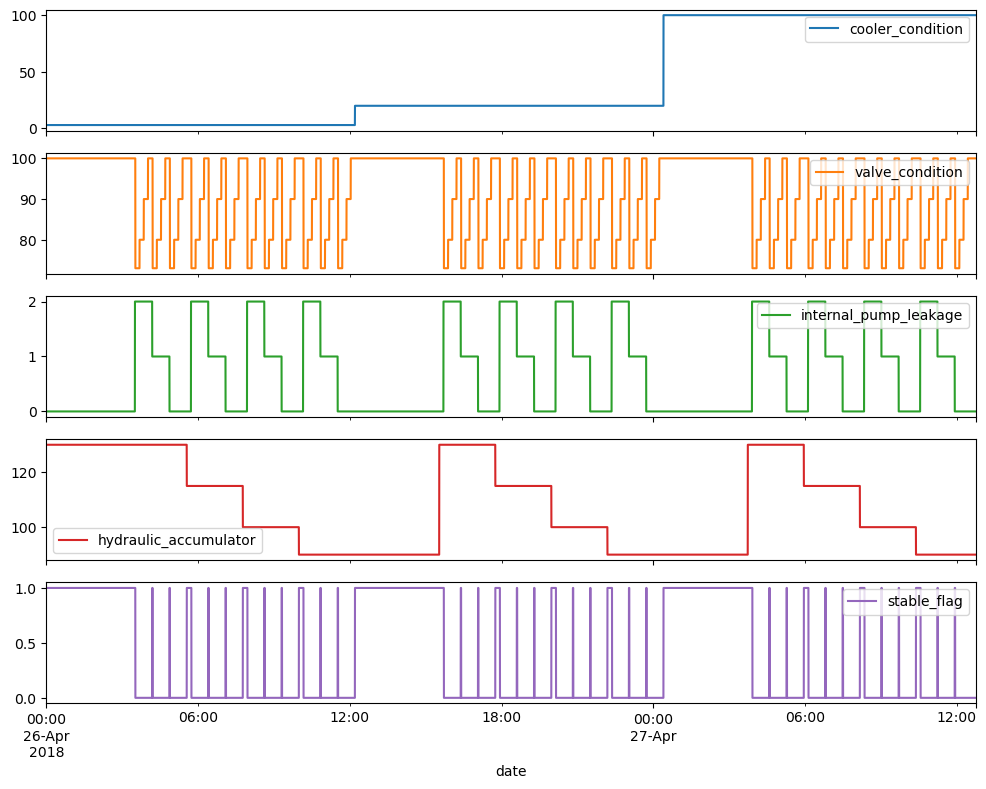

In [24]:
df.plot(x='date', 
        y=['cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'],
        figsize=(10,8),
        subplots=True)
plt.tight_layout()
plt.show()

# Feature Importance - XGBoost


Target: cooler_condition
Feature: SE, Importance: 0.00012805974984075874
Feature: PS1, Importance: 0.00016584208060521632
Feature: TS4, Importance: 0.22975359857082367
Feature: PS2, Importance: 7.580091914860532e-05
Feature: PS3, Importance: 0.00017166120233014226
Feature: TS3, Importance: 0.0014216749696061015
Feature: VS1, Importance: 0.00015831764903850853
Feature: TS2, Importance: 0.0006996036972850561
Feature: PS6, Importance: 0.00011793487647082657
Feature: PS4, Importance: 0.00046792716602794826
Feature: TS1, Importance: 0.0008193912217393517
Feature: PS5, Importance: 0.00019036262528970838
Feature: CP, Importance: 0.0028675785288214684
Feature: CE, Importance: 0.7573316693305969
Feature: EPS1, Importance: 0.0007059745257720351
Feature: FS1, Importance: 0.0006015240796841681
Feature: FS2, Importance: 0.004322983790189028


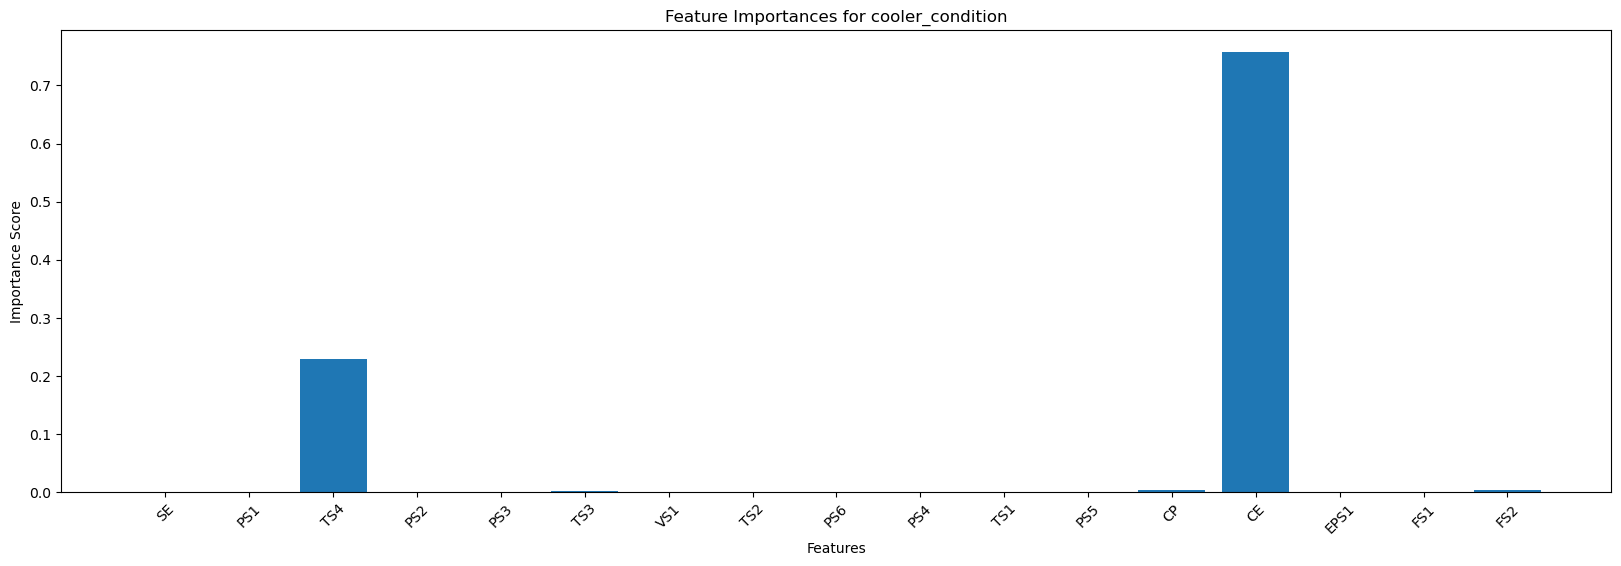


Target: valve_condition
Feature: SE, Importance: 0.03731913864612579
Feature: PS1, Importance: 0.06057002767920494
Feature: TS4, Importance: 0.13483566045761108
Feature: PS2, Importance: 0.030069155618548393
Feature: PS3, Importance: 0.02471543475985527
Feature: TS3, Importance: 0.08345333486795425
Feature: VS1, Importance: 0.01818423718214035
Feature: TS2, Importance: 0.0540669709444046
Feature: PS6, Importance: 0.0517144575715065
Feature: PS4, Importance: 0.06457404792308807
Feature: TS1, Importance: 0.03772334009408951
Feature: PS5, Importance: 0.06670241057872772
Feature: CP, Importance: 0.0342487171292305
Feature: CE, Importance: 0.028277337551116943
Feature: EPS1, Importance: 0.030849115923047066
Feature: FS1, Importance: 0.19306015968322754
Feature: FS2, Importance: 0.04963640868663788


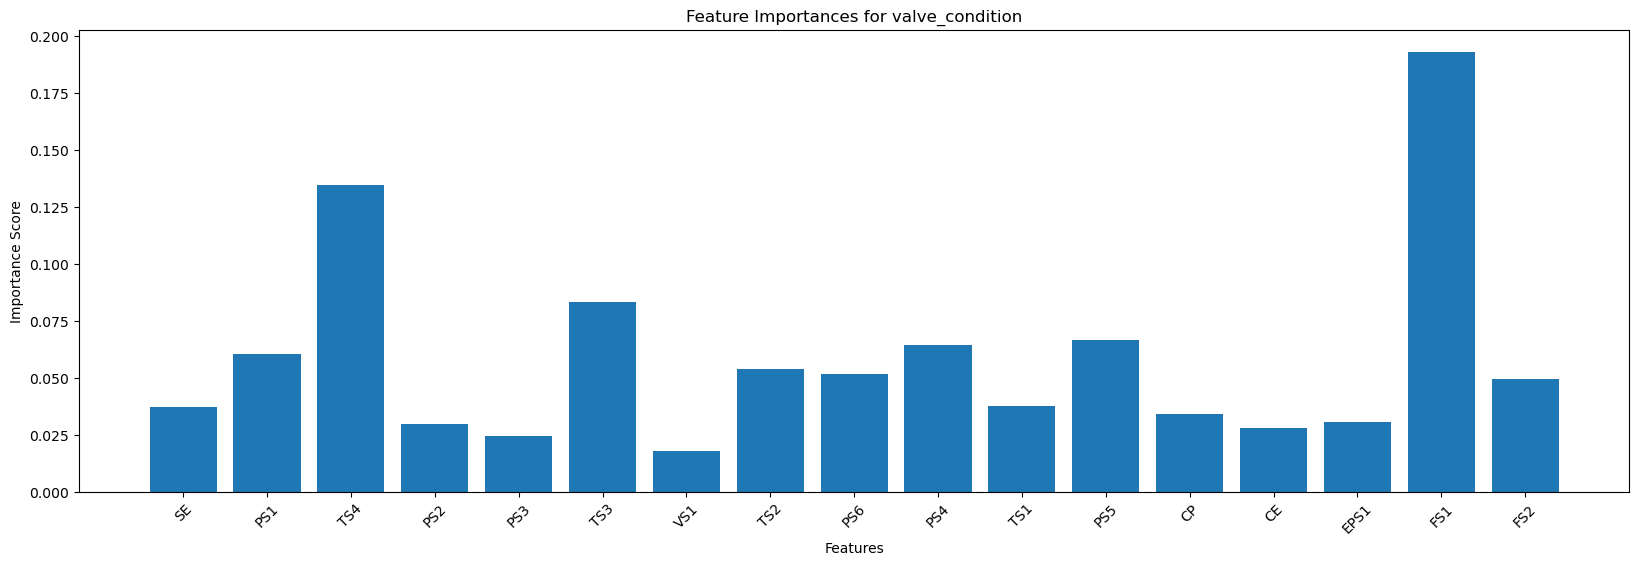


Target: internal_pump_leakage
Feature: SE, Importance: 0.2672189772129059
Feature: PS1, Importance: 0.08333513885736465
Feature: TS4, Importance: 0.055205997079610825
Feature: PS2, Importance: 0.05854964628815651
Feature: PS3, Importance: 0.020529931411147118
Feature: TS3, Importance: 0.03052169270813465
Feature: VS1, Importance: 0.018088048323988914
Feature: TS2, Importance: 0.026479709893465042
Feature: PS6, Importance: 0.010318953543901443
Feature: PS4, Importance: 0.04382597282528877
Feature: TS1, Importance: 0.029205335304141045
Feature: PS5, Importance: 0.01804278790950775
Feature: CP, Importance: 0.011713012121617794
Feature: CE, Importance: 0.003911760635674
Feature: EPS1, Importance: 0.04979686066508293
Feature: FS1, Importance: 0.26496219635009766
Feature: FS2, Importance: 0.008293949998915195


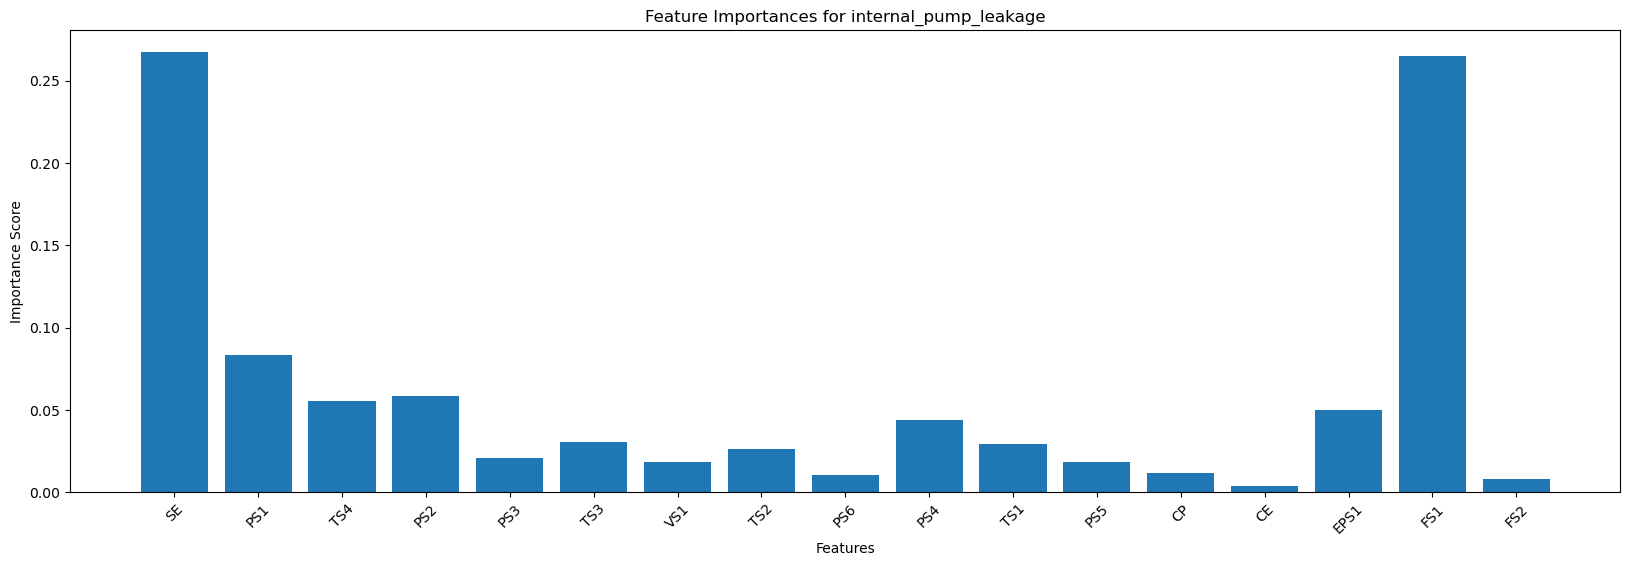


Target: hydraulic_accumulator
Feature: SE, Importance: 0.007861007936298847
Feature: PS1, Importance: 0.007911059074103832
Feature: TS4, Importance: 0.20285646617412567
Feature: PS2, Importance: 0.013165214098989964
Feature: PS3, Importance: 0.00858237873762846
Feature: TS3, Importance: 0.09064514189958572
Feature: VS1, Importance: 0.006062656175345182
Feature: TS2, Importance: 0.06163591146469116
Feature: PS6, Importance: 0.01844153180718422
Feature: PS4, Importance: 0.29976898431777954
Feature: TS1, Importance: 0.009304916486144066
Feature: PS5, Importance: 0.028499066829681396
Feature: CP, Importance: 0.11357877403497696
Feature: CE, Importance: 0.024157417938113213
Feature: EPS1, Importance: 0.015196321532130241
Feature: FS1, Importance: 0.009001951664686203
Feature: FS2, Importance: 0.08333125710487366


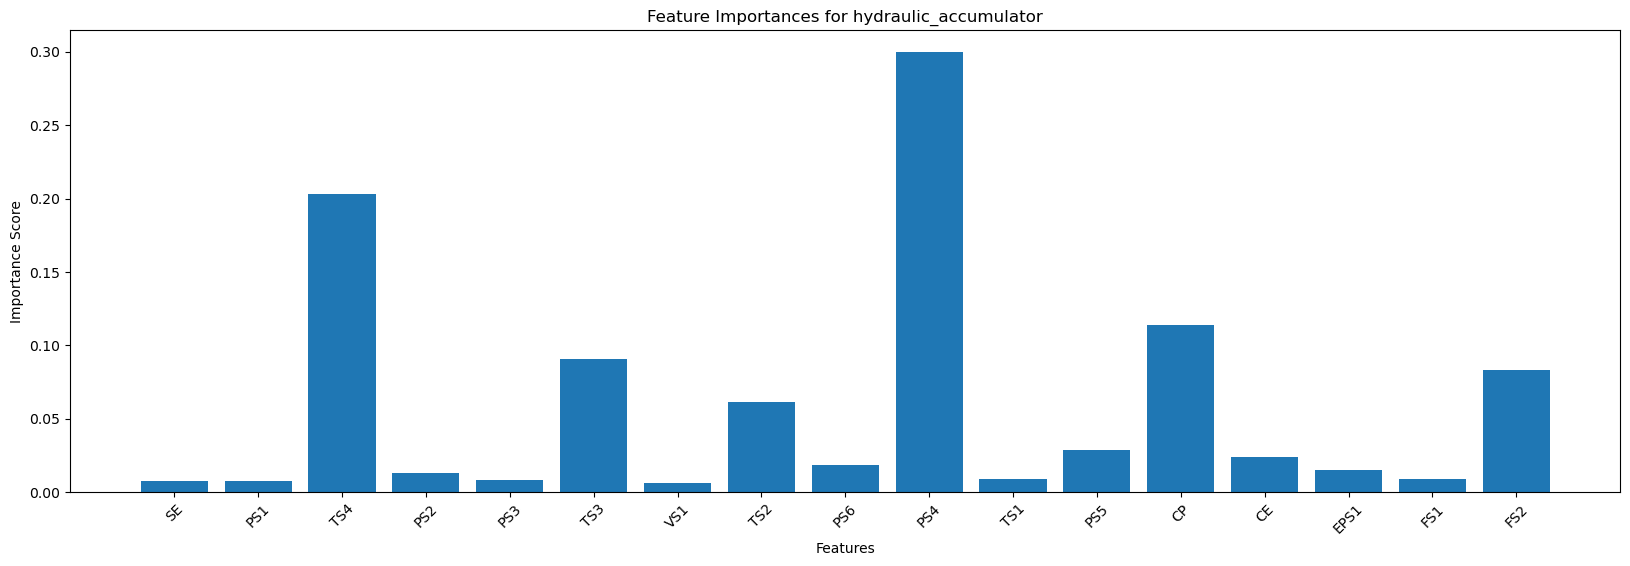


Target: stable_flag
Feature: SE, Importance: 0.000353079114574939
Feature: PS1, Importance: 0.00045757769839838147
Feature: TS4, Importance: 0.008708985522389412
Feature: PS2, Importance: 0.0008440168458037078
Feature: PS3, Importance: 0.00026501057436689734
Feature: TS3, Importance: 0.010032965801656246
Feature: VS1, Importance: 0.0006258201319724321
Feature: TS2, Importance: 0.0058841826394200325
Feature: PS6, Importance: 0.0028029796667397022
Feature: PS4, Importance: 0.0019371090456843376
Feature: TS1, Importance: 0.003719678381457925
Feature: PS5, Importance: 0.026792112737894058
Feature: CP, Importance: 0.001977118430659175
Feature: CE, Importance: 0.0016442111227661371
Feature: EPS1, Importance: 0.0008848434663377702
Feature: FS1, Importance: 0.0005078747635707259
Feature: FS2, Importance: 0.0020670725498348475
Feature: cooler_condition, Importance: 0.004664946347475052
Feature: valve_condition, Importance: 0.845362663269043
Feature: internal_pump_leakage, Importance: 0.0732870

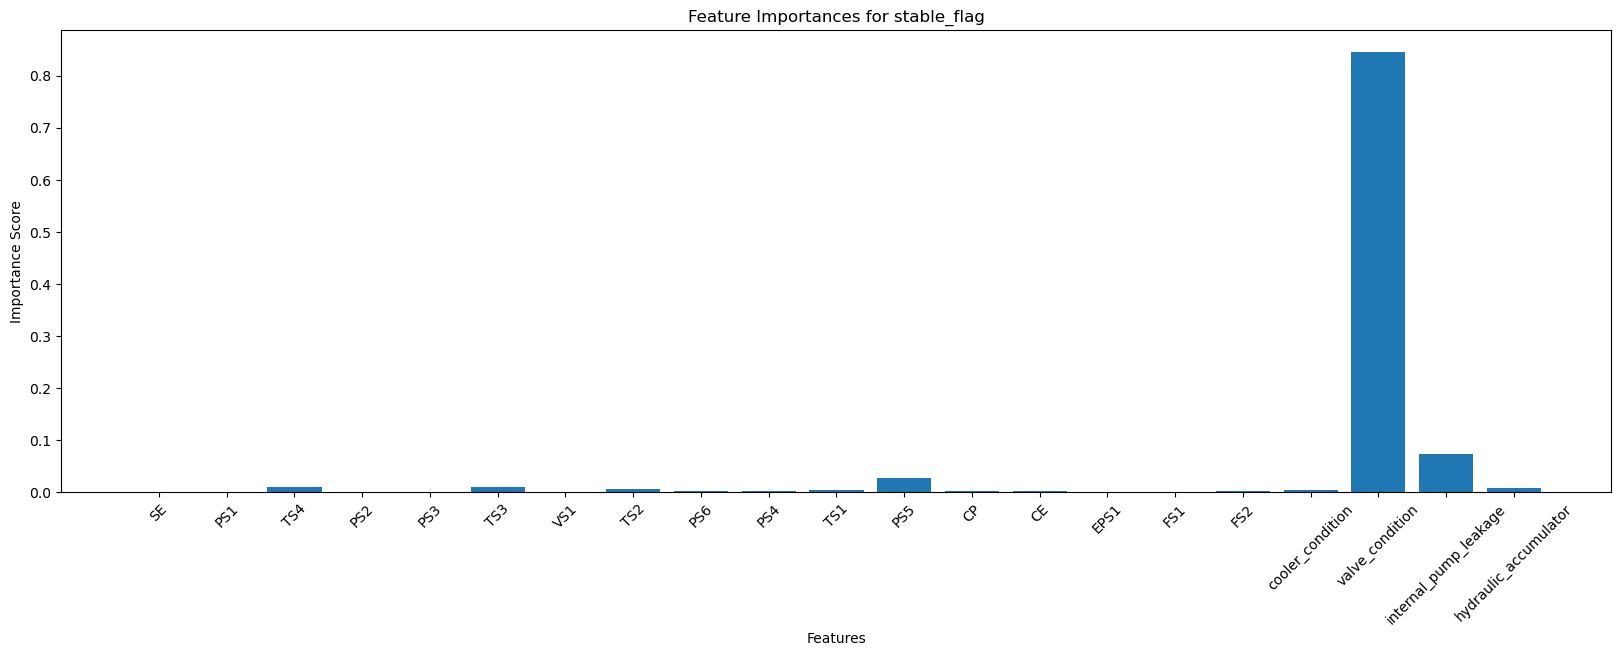

In [25]:
import xgboost as xgb
from sklearn.model_selection import train_test_split



# Separate features (X) and target (y) variables
X = df.drop(columns = ['date','seconds', 'cycle','cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'])  
targets = ['cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag']


# Loop through each target and create a separate XGBoost model
for target in targets:
    y = df[target] 

    # Apply mapping and set num_class based on the target variable
    if target == 'cooler_condition':
        mapping = {3: 0, 20: 1, 100: 2}
        num_class = 3
    elif target == 'valve_condition':
        mapping = {73: 0, 80: 1, 90: 2, 100: 3}
        num_class = 4
    elif target == 'internal_pump_leakage':
        num_class = 3
    elif target == 'hydraulic_accumulator':
        mapping = {90: 0, 100: 1, 115: 2, 130: 3}
        num_class = 4
    else:
        num_class = 2
        X = df.drop(columns = ['date','seconds', 'cycle', 'stable_flag'])  

    y = y.replace(mapping)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False, random_state=42)

    # Create an XGBoost multi-class classifier
    model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_class)

    # Train the model
    model.fit(X_train, y_train)

    # Get feature importances
    importances = model.feature_importances_

    # Display feature importances
    print(f"\nTarget: {target}")
    for feature, importance in zip(X.columns, importances):
        print(f"Feature: {feature}, Importance: {importance}")

    # Plot feature importances
    fig, ax = plt.subplots(figsize = (20,6))
    ax.bar(X.columns, importances)
    ax.set_xlabel('Features')
    ax.set_ylabel('Importance Score')
    ax.set_title(f"Feature Importances for {target}")
    plt.xticks(rotation=45)
    plt.show()


# Scaling Data

In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), QuantileTransformer(output_distribution='normal'), PowerTransformer(method='yeo-johnson')]
scaler_names = ['StandardScaler', 'RobustScaler', 'MinMaxScaler', 'QuantileTransformer', 'PowerTransformer']

classifiers = [LogisticRegression(), RandomForestClassifier(), SVC(), xgb.XGBClassifier()]
classifier_names = ['LogisticRegression', 'RandomForestClassifier', 'SVC', 'XGBClassifier']

scoring = ['recall_macro', 'f1_macro', 'precision_macro', 'accuracy']

# Create an instance of TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Scaler', 'Classifier'] + scoring)

# Loop through the scalers and classifiers
for scaler, scaler_name in zip(scalers, scaler_names):
    for classifier, classifier_name in zip(classifiers, classifier_names):
        
        # Create a pipeline with the scaler and the classifier
        pipeline = Pipeline([('scaler', scaler), ('classifier', classifier)])
        
        # Evaluate the pipeline using TimeSeriesSplit cross-validation
        scores = cross_validate(pipeline, X_train, y_train, cv=tscv, scoring=scoring)
        
        # Compute the mean scores for each metric
        mean_scores = [np.mean(scores[f'test_{metric}']) for metric in scoring]
        
        # Append the results to the results DataFrame
        results_df = results_df.append(pd.Series([scaler_name, classifier_name] + mean_scores, index=results_df.columns), ignore_index=True)


/Users/duckman/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/duckman/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [28]:
results_df.sort_values(by = "recall_macro", ascending=False)

,Scaler,Classifier,recall_macro,f1_macro,precision_macro,accuracy
15,QuantileTransformer,XGBClassifier,0.915773,0.865398,0.846008,0.914887
19,PowerTransformer,XGBClassifier,0.906270,0.860653,0.844702,0.911995
3,StandardScaler,XGBClassifier,0.904952,0.839843,0.824421,0.895159
7,RobustScaler,XGBClassifier,0.904952,0.839843,0.824421,0.895159
11,MinMaxScaler,XGBClassifier,0.904952,0.839843,0.824421,0.895159
13,QuantileTransformer,RandomForestClassifier,0.872320,0.819832,0.821021,0.871327
17,PowerTransformer,RandomForestClassifier,0.869277,0.814206,0.819248,0.865215
5,RobustScaler,RandomForestClassifier,0.863989,0.807326,0.816893,0.857551
1,StandardScaler,RandomForestClassifier,0.847991,0.784248,0.810052,0.833617
9,MinMaxScaler,RandomForestClassifier,0.842223,0.775691,0.808549,0.825272
